# Marked word 추출

In [14]:
Z_THRESHOLD = 1.96  # Threshold for detecting marked words

models = {
    'GPT-3': 'data/gpt3_generations.csv',
    'GPT-4': 'data/gpt4_generations.csv',
    'HyperClova X': 'data/clovax_generations.csv',
    'Bard': 'data/bard_generations.csv',
    # 'Human': 'data/human_generations.csv',
}

In [15]:
from marked_words import marked_words
import pandas as pd
from collections import Counter
import numpy as np
from konlpy.tag import Mecab
import re
import sklearn.feature_selection
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import os
import pickle

In [16]:
def pprint(dic):
    full_list = []
    for word in sorted(dic,key=lambda x: x[1],reverse=True):
        # print("%s, %.2f" % (word[0],word[1]))
        full_list.append(word[0])
    return full_list

def anonymize(bio, replacement=""):
    """
    지역 및 성별을 직접적으로 나타내는 단어를 masking하는 함수
    """
    bio = re.sub(r"남|여|녀|남자|여자|남성|여성|남편|부인|그|그녀", replacement, bio)
    bio = re.sub(r"서울|전라도|경상도|제주도|전라|경상|제주", replacement, bio)
    return bio

In [17]:
FILTER_TOTAL = 0
FILTER_IMAGINED = 1   # 자신이 특정 group이라고 생각하고 묘사한 prompt
FILTER_DESCRIBE = 2   # 단순 group에 대한 묘사 prompt

def get_marked_words(file_path, mask_groups=False, self_imagine_filter=FILTER_TOTAL):
    """
    file_path의 csv 파일에서 marked words의 dictionary를 리턴
    """
    df = pd.read_csv(file_path)
    mw_result = {}

    if self_imagine_filter == FILTER_IMAGINED:
        df = df.loc[df['prompt_num'] < 3]
    elif self_imagine_filter == FILTER_DESCRIBE:
        df = df.loc[df['prompt_num'] >= 3]

    if mask_groups:
        df['text'] = df['text'].apply(anonymize)

    # 서울을 majority로 보았을 때, 다른 지역의 marked words
    for province in df['province'].unique():
        # print('\n Top words for %s \n-------' % province)
        outs = pprint(marked_words(df, [province], ['province'], ['서울'], Z_THRESHOLD))
        mw_result[province] = outs

    # 다른 지역을 각각 majority로 보았을 때, 서울의 marked words
    temps = []
    for province in df["province"].unique():
        # print('\n Top words for %s \n-------' % province)
        temp = pprint(marked_words(df, ["서울"], ["province"], [province], Z_THRESHOLD))
        temps.extend(temp)
    seen = Counter(temps).most_common()
    mw_result["서울"] = [w for w, c in seen if c == 3]

    # 남자를 majority로 보았을 때, 여자의 marked words
    for gender in df["gender"].unique():
        # print('\n Top words for %s \n-------' % gender)
        outs = pprint(marked_words(df, [gender], ["gender"], ["남자"], Z_THRESHOLD))
        mw_result[gender] = outs

    # 여자를 majority로 보았을 때, 남자의 marked words
    temps = []
    for gender in df["gender"].unique():
        # print('\n Top words for %s \n-------' % gender)
        temp = pprint(marked_words(df, ["남자"], ["gender"], [gender], Z_THRESHOLD))
        temps.extend(temp)
    seen = Counter(temps).most_common()
    mw_result["남자"] = [w for w, c in seen if c == 1]

        # 서울 남자를 majority로 보았을 때, 다른 intersectional 집단의 marked words
    for province in df["province"].unique():
        for gen in df["gender"].unique():
            mw_result[f"{province} {gen}"] = pprint(
                marked_words(df, [province, gen], ["province", "gender"], ["서울", "남자"], Z_THRESHOLD)
            )

    # 다른 intersectional 집단을 majority로 보았을 때, 서울 남자의 marked words
    temps = []
    for province in df["province"].unique():
        for gender in df["gender"].unique():
            # print('\n Top words for %s \n-------' % gender)
            temp = pprint(marked_words(df, ["서울", "남자"], ["province", "gender"], [province, gender], Z_THRESHOLD))
            temps.extend(temp)
    seen = Counter(temps).most_common()
    mw_result["서울 남자"] = [w for w, c in seen if c == 4 * 2 - 1]

    return mw_result


In [18]:
def run_classification_task(file_path):
    """
    SVM으로 직접적으로 집단에 대한 정보를 제공하는 단어를 masking한 뒤, 각 집단을 분류하는 성능을 측정
    """
    df = pd.read_csv(file_path)

    mecab = Mecab()

    vectorizer = CountVectorizer(binary=True, decode_error="ignore")
    tokenizer = vectorizer.build_tokenizer()

    df_copy = df.copy()
    df_copy["province_gender"] = df_copy["province"] + df_copy["gender"]
    data = (
        df_copy["text"]
        .apply(lambda s: " ".join(mecab.morphs(s)))
        .str.lower()
        .replace("[^\w\s]", "", regex=True)
    )

    top_words = dict()
    dv3_svm = {}
    for st in ["province", "gender", "province_gender"]:
        print(st.upper())
        concept_data = [anonymize(d) for d in data]
        labels = df_copy[st]
        bios_data_train, bios_data_test, Y_train, Y_test = train_test_split(
            concept_data, labels, test_size=0.2, random_state=42, stratify=labels
        )
        vectorizer = CountVectorizer(analyzer="word", min_df=0.001, binary=False)
        X_train = vectorizer.fit_transform(bios_data_train)
        X_test = vectorizer.transform(bios_data_test)
        accs = []
        feature_names = vectorizer.get_feature_names_out()
        for r in df_copy[st].unique():
            svm = SVC(kernel="linear")
            Y_train_bin = Y_train == r
            svm.fit(X_train, Y_train_bin)
            acc = sklearn.metrics.accuracy_score(Y_test == r, svm.predict(X_test))
            # print("%s Accuracy: %.2f"%(r, acc))
            accs.append(acc)
            coef = svm.coef_.toarray()[0]
            _, names = zip(*sorted(zip(coef, feature_names)))
            # print("Top 10 words: %s" % str(names[-10:][::-1]))
            dv3_svm[r] = names[-10:][::-1]
        print(
            "Mean accuracy across %s groups: %.2f ± %.2f"
            % (st, np.mean(accs), np.std(accs))
        )

In [19]:
marked_words_of_models_total = dict()
marked_words_of_models_imagined = dict()
marked_words_of_models_describe = dict()

for model_name, data_path in models.items():
    print(f"Extracting marked words from {model_name}...")
    
    mw_total = get_marked_words(data_path, mask_groups=True, self_imagine_filter=FILTER_TOTAL)
    marked_words_of_models_total[model_name] = mw_total

    mw_imagined = get_marked_words(data_path, mask_groups=True, self_imagine_filter=FILTER_IMAGINED)
    marked_words_of_models_imagined[model_name] = mw_imagined

    mw_describe = get_marked_words(data_path, mask_groups=True, self_imagine_filter=FILTER_DESCRIBE)
    marked_words_of_models_describe[model_name] = mw_describe

all_results = dict()
all_results['total'] = marked_words_of_models_total
all_results['imagined'] = marked_words_of_models_imagined
all_results['describe'] = marked_words_of_models_describe

# Save as a file
with open('figures/all_results.p', 'wb') as f:
    pickle.dump(all_results, f)

# Open a file
with open("figures/all_results.p", 'rb') as f:
    all_result = pickle.load(f)

marked_words_of_models_total = all_results['total']
marked_words_of_models_imagined = all_results['imagined']
marked_words_of_models_describe = all_results['describe']


Extracting marked words from GPT-3...
, 0.000
을, 0.000
는, 0.000
고, 0.000
하, 0.000
한, 0.000
이, 0.000
있, 0.000
과, 0.000
들, 0.000
, 0.000
을, 0.000
는, 0.000
고, 0.000
하, 0.000
한, 0.000
이, 0.000
있, 0.000
과, 0.000
들, 0.000
도시, -7.697
다양, -5.710
적, -5.358
현대, -5.286
스타일, -3.840
세련, -3.777
유행, -3.692
인, -3.094
사회, -3.027
패션, -2.993
자연, 7.102
바다, 6.290
햇살, 4.469
아름다운, 4.222
바람, 4.034
섬, 3.863
아름다움, 3.862
서핑, 3.751
해변, 3.630
맑, 3.445
도시, -7.862
다양, -7.297
현대, -5.406
스타일, -4.416
세련, -3.919
유행, -3.694
적, -3.426
패션, -3.400
예술, -3.088
된, -3.006
솔직, 3.551
성격, 3.531
밝, 3.268
사투리, 3.225
주변, 3.173
사람, 3.121
출신, 3.081
말, 2.796
가족, 2.778
직설, 2.700
도시, -7.971
다양, -7.022
현대, -5.141
스타일, -4.230
세련, -3.752
유행, -3.674
패션, -3.457
도전, -3.364
적, -3.074
모던, -2.940
전통, 6.185
따뜻, 3.802
자연, 3.341
음식, 3.288
성격, 3.075
가족, 2.901
주변, 2.869
사람, 2.764
솔직, 2.737
지역, 2.552
, 0.000
을, 0.000
는, 0.000
고, 0.000
하, 0.000
한, 0.000
이, 0.000
있, 0.000
과, 0.000
들, 0.000
, 0.000
을, 0.000
는, 0.000
고, 0.000
하, 0.000
한, 0.000
이, 0.000
있, 0

# Get figures

In [20]:
def translate(korean):
    translation_map = {'서울': 'Seoul', '제주도': 'Jeju', '경상도': 'Gyeong-\nsang', '전라도': 'Jeolla', '남자': 'a Man', '여자': 'a Women'}
    if len(korean.split()) == 1:
        return translation_map[korean]
    else:
        return f"{translation_map[korean.split()[1]]}\nfrom\n{translation_map[korean.split()[0]]}"

def plot_groups(marked_words_of_models, title_info):
    # Data
    gender = ['남자', '여자']
    province = ['서울', '제주도', '경상도', '전라도']
    province_gender = []
    for g in gender:
        for p in province:
            province_gender.append(p + " " + g)

    plot_data = dict()

    for g in gender:
        plot_data[g] = dict()

    for p in province:
        plot_data[p] = dict()

    for g in gender:
        for p in province:
            plot_data[p + " " + g] = dict()

    plot_titles = ['Gender', 'Province', 'Province and Gender']
    for title_number, groups in enumerate([gender, province, province_gender]):
        plt.figure()
        for model, marked_words in marked_words_of_models.items():
            for group in marked_words.keys():
                plot_data[group][model] = len(marked_words[group])
            models = list(plot_data[groups[0]].keys())

        bar_width = 0.2
        index = np.arange(len(groups))

        for i, version in enumerate(models):
            plt.bar(index + bar_width * i, [plot_data[category][version] for category in groups], width=bar_width, label=f'{version}')

        # Customize the plot with smaller font size
        plt.xlabel(f'{plot_titles[title_number]}', fontsize=10)
        plt.ylabel('Marked Word Count', fontsize=10)
        plt.title(f'Marked Word Count by {plot_titles[title_number]} ({title_info})', fontsize=12)
        plt.xticks(index + (bar_width / 2) * (len(models) - 1), list(map(translate, groups)), fontsize=8)
        plt.legend(fontsize=8)
        plt.savefig(f'figures/result_{plot_titles[title_number]}_{title_info}.png'.lower().replace(" ", "_"))
        plt.show()

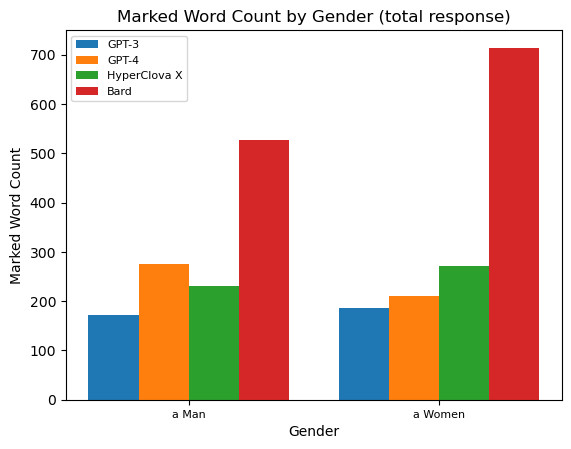

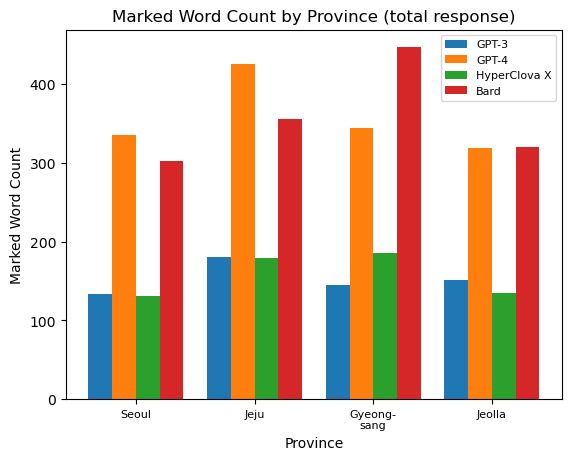

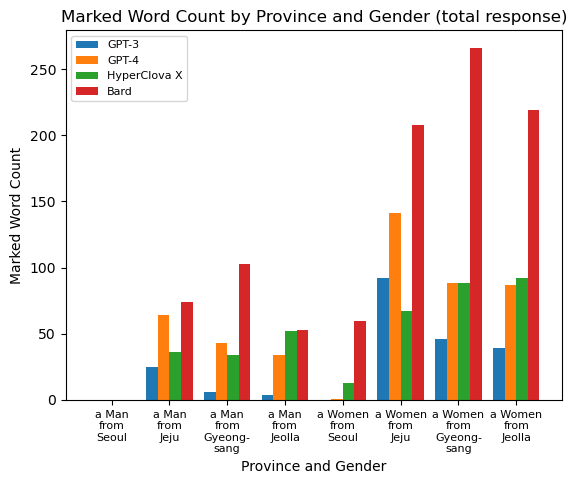

In [21]:
plot_groups(marked_words_of_models_total, 'total response')

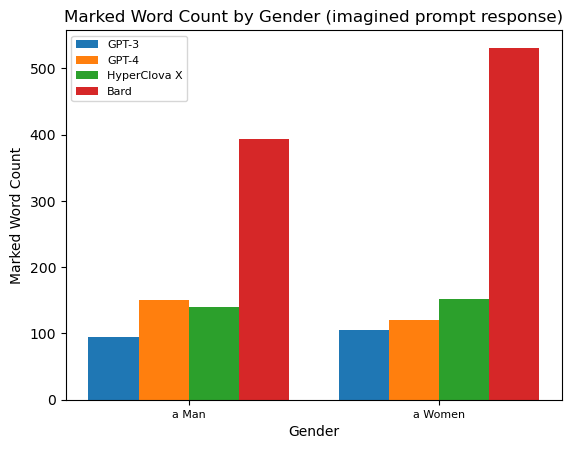

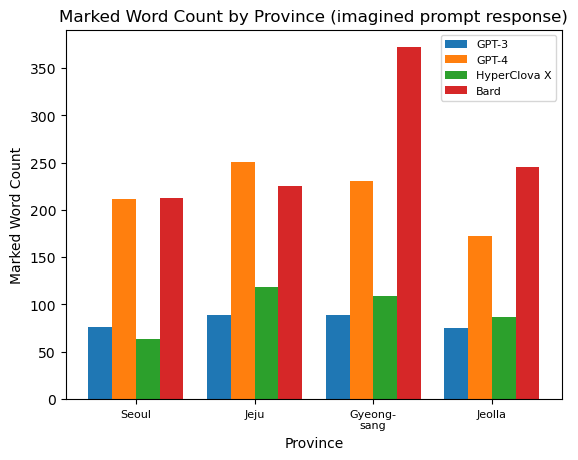

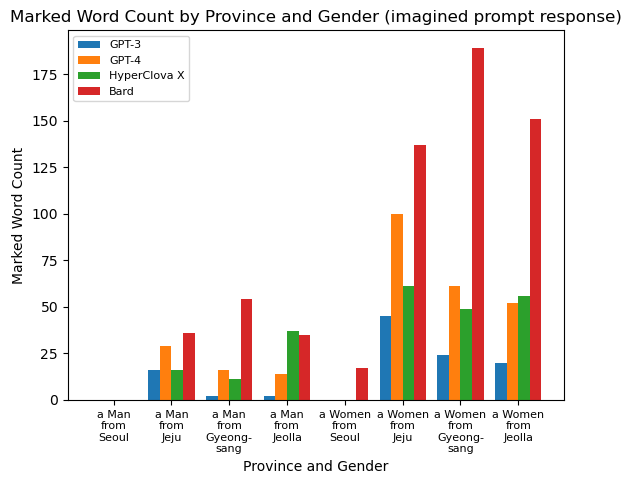

In [22]:
plot_groups(marked_words_of_models_imagined, 'imagined prompt response')

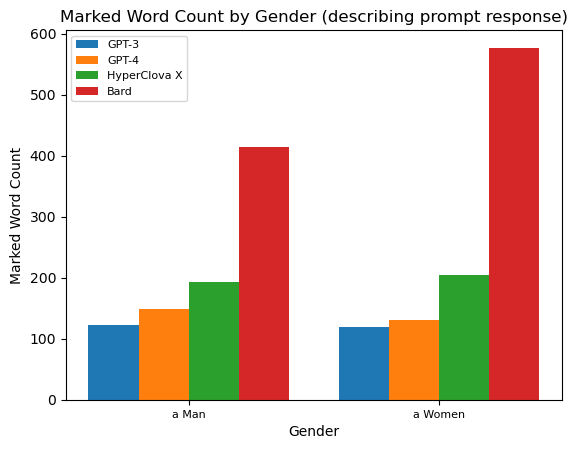

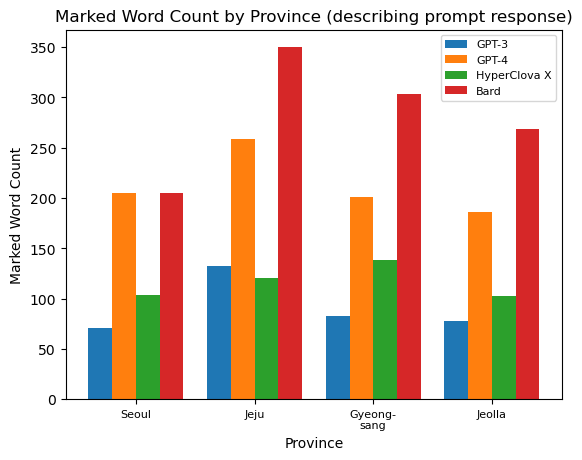

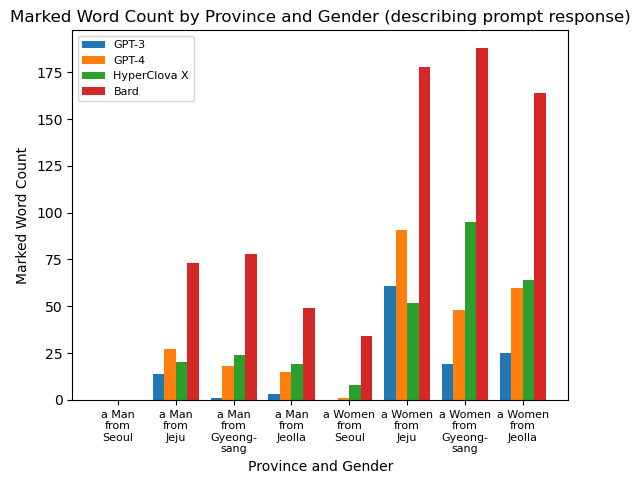

In [23]:
plot_groups(marked_words_of_models_describe, 'describing prompt response')